# 画像メディア工学９回目　その２
## ディープラーニングでステレオマッチング（３次元復元）

様々な手法があるが，ここでは[Pyramid Stereo Matching Network](https://arxiv.org/abs/1803.08669) (PSMNet) を利用してみる．

※ このプログラムは，Sonyのディープラーニングライブラリ[Neural Network Libraries (nnabla)](https://github.com/sony/nnabla/)の[PSMNetのサンプルプログラム](https://colab.research.google.com/github/sony/nnabla-examples/blob/master/interactive-demos/psmnet.ipynb) を参考にしています．また，PSMNet以外にも様々なサンプルが用意されています (https://github.com/sony/nnabla-examples)

## 準備の前に

Colabでは，`!cat /etc/os-release` といった形で，先頭に`!`をつけることで，シェルコマンド（Linuxのコマンド）を実行できる．

`!cat /etc/os-release`と実行すると，OS情報が表示される．以下の場合，Ubuntu 22.04.3 LTSであることがわかる．

`cat`コマンドはファイルの中身を表示するコマンドで，`/etc/os-release`ファイルの中身を表示せよ，という意味．`/etc/os-release`ファイルには，OSのバージョンなどの情報が保存されている．

In [1]:
!cat /etc/os-release

PRETTY_NAME="Ubuntu 22.04.3 LTS"
NAME="Ubuntu"
VERSION_ID="22.04"
VERSION="22.04.3 LTS (Jammy Jellyfish)"
VERSION_CODENAME=jammy
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=jammy


`ls`は，現在のディレクトリのファイル一覧を表示するLinuxのコマンドで，Windowsでの`dir`にあたる．

ステレオマッチングまでの完了した段階で`ls`コマンドを実行すると以下のようになる．

In [2]:
!ls

sample_data


## 前準備
Colabにはnnablaがインストールされていないため，インストールする．

その後，PSMNetのプログラムと必要なファイルを実行場所にコピーする．

（ただし，セッションが切れると再インストールが必要になります）

また，以下のプログラムを実行する際は，メニューの「ランタイム」→「ランタイムのタイプを変更」を開き、ハードウェアアクセラレータをGPUに設定してください．

In [3]:
# May show warnings for newly imported packages if run in Colab default python environment.
# Please click the `RESTART RUNTIME` to run the following script correctly.
# The error message of conflicts is acceptable.
!pip install nnabla-ext-cuda116
!git clone https://github.com/sony/nnabla-examples.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: Cython
    Found existing installation: Cython 3.0.6
    Uninstalling Cython-3.0.6:
      Successfully uninstalled Cython-3.0.6
ERROR: pip's dependency resolver does not current

Cloning into 'nnabla-examples'...
remote: Enumerating objects: 9643, done.
remote: Counting objects: 100% (2201/2201), done.
remote: Compressing objects: 100% (880/880), done.
remote: Total 9643 (delta 1280), reused 2117 (delta 1261), pack-reused 7442
Receiving objects: 100% (9643/9643), 298.96 MiB | 37.41 MiB/s, done.
Resolving deltas: 100% (5244/5244), done.
Updating files: 100% (1711/1711), done.


In [4]:
%cd nnabla-examples/stereo-depth/PSMnet

/content/nnabla-examples/stereo-depth/PSMnet


学習済みモデル（重み）をダウンロード．

In [5]:
# get PSMNet pretrained weights trained on Scene Flow Datasets.
!wget https://nnabla.org/pretrained-models/nnabla-examples/stereo-depth/psmnet_trained_sceneflow.h5

--2023-12-07 05:48:48--  https://nnabla.org/pretrained-models/nnabla-examples/stereo-depth/psmnet_trained_sceneflow.h5
Resolving nnabla.org (nnabla.org)... 18.164.174.6, 18.164.174.62, 18.164.174.103, ...
Connecting to nnabla.org (nnabla.org)|18.164.174.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16476824 (16M) [binary/octet-stream]
Saving to: ‘psmnet_trained_sceneflow.h5’

psmnet_trained_scen 100%[===================>]  15.71M  36.3MB/s    in 0.4s    

2023-12-07 05:48:49 (36.3 MB/s) - ‘psmnet_trained_sceneflow.h5’ saved [16476824/16476824]



## ステレオマッチングの実行

セッションが切れない限り，前処理は一度行えば良いため，
別画像に対して実行したい場合，以降の処理のみを再実行すれば良い．

### ステレオマッチング用の画像のアップロード

以下の2枚の画像をgithubよりダウンロードし，Colabにアップしてください．

左：https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img08_left.png

右：https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img08_right.png

Left | Right
--- | ---
<img src="https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img08_left.png" width="400px">|<img src="https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img08_right.png" width="400px">

※ ここでは，以下のデータセットのFlyingThings3Dの画像（Sample packに含まれるもの）を利用しています．

https://lmb.informatik.uni-freiburg.de/resources/datasets/SceneFlowDatasets.en.htm


In [6]:
!wget https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img08_left.png
!wget https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img08_right.png

--2023-12-07 05:48:49--  https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img08_left.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 708478 (692K) [image/png]
Saving to: ‘img08_left.png’

img08_left.png      100%[===================>] 691.87K  --.-KB/s    in 0.04s   

2023-12-07 05:48:49 (18.4 MB/s) - ‘img08_left.png’ saved [708478/708478]

--2023-12-07 05:48:49--  https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img08_right.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70754

### PSMNetを実行
まず，Colabにアップロードしたファイル名を指定する．

In [7]:
left_image_path  = "img08_left.png"
right_image_path = "img08_right.png"

次に，ColabにダウンロードしたPSMNetのスクリプトを実行する．


In [8]:
!python inference.py --dataset SceneFlow --loadmodel ./psmnet_trained_sceneflow.h5 --save-nnp False -l $left_image_path -r $right_image_path

2023-12-07 05:48:51,021 [nnabla][INFO]: Initializing CPU extension...
2023-12-07 05:48:52,028 [nnabla][INFO]: Initializing CUDA extension...
2023-12-07 05:48:52,110 [nnabla][INFO]: Initializing cuDNN extension...
False
Done
2023-12-07 05:49:03,202 [nnabla][INFO]: Saving psmnet_kitti.nnp as nnp
2023-12-07 05:49:03,203 [nnabla][INFO]: Saving <_io.StringIO object at 0x7b6f04dd20e0> as prototxt
2023-12-07 05:49:03,823 [nnabla][INFO]: Parameter save (.h5): <_io.BytesIO object at 0x7b6f03ca2890>
2023-12-07 05:49:03,869 [nnabla][INFO]: Model file is saved as (.nnp): psmnet_kitti.nnp


### 処理結果の可視化
おまじない

In [9]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc

可視化に必要な変数の設定

In [10]:
depth_img = cv2.imread("stereo_depth.png",0)
left_img = cv2.imread(left_image_path)

h,w = depth_img.shape
X, Y = np.meshgrid(np.arange(0,w), np.arange(0,h))

3次元復元結果の可視化．
アニメーションを生成するため，実行完了まで数十秒かかる．

実行完了すると，再生ボタンを押すとグラフが回転し，3次元復元ができていることが分かる．

(Github上では見られません）

In [11]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')
ax.invert_xaxis()

def init():
  ax.plot_surface(X, Y, depth_img, cmap='jet')
  return fig,

def animate(i):
  ax.view_init(elev=90.-i*5, azim=90.+i)
  return fig,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=18, interval=200, blit=True)

rc('animation', html='jshtml')
plt.close()
anim

推定されたデプス画像とステレオマッチングに用いた元画像の表示

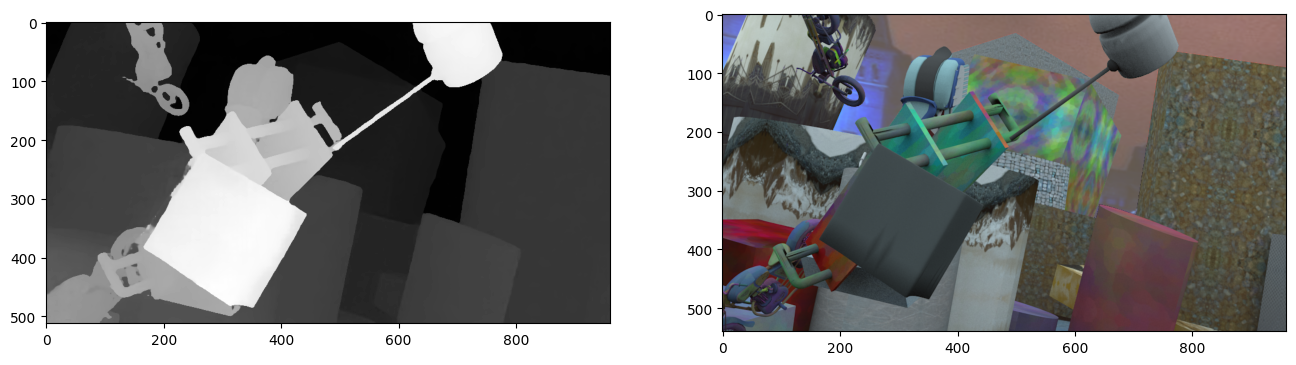

In [12]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.imshow(depth_img, cmap="gray")
plt.subplot(1,2,2)
plt.imshow(left_img, cmap="gray")